# Insurance cost prediction using linear regression

Make a submisson here: https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/assignment/assignment-2-train-your-first-model

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from [Kaggle](https://www.kaggle.com/mirichoi0218/insurance).


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lessons. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ai/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ai/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ai/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [2]:
# Uncomment and run the appropriate command for your operating system, if required

# Linux / Binder
# !pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Windows
# !pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS
# !pip install numpy matplotlib pandas torch torchvision torchaudio

In [101]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [102]:
project_name='02-insurance-linear-regression_Assignment' # will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [5]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [6]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()
len(dataframe_raw)

1338

We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [7]:
your_name = 'pragya'# at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [8]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [9]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()


age     sex      bmi  children smoker       charges
13     56  female  45.3948         0     no  10757.996266
367    42  female  28.4829         2     no   7776.549316
623    18    male  38.2299         0    yes  33579.305430
1281   47  female  31.5153         2    yes  23799.627594
966    51    male  28.2663         2    yes  23248.361559

Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [10]:
num_rows = 1271
print(num_rows)

1271


**Q: How many columns doe the dataset have**

In [11]:
num_cols = 6
print(num_cols)

6


**Q: What are the column titles of the input variables?**

In [12]:
input_cols = ['age','sex','bmi','children','smoker']

**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [13]:
categorical_cols = ['sex','smoker']

**Q: What are the column titles of output/target variable(s)?**

In [14]:
output_cols = ['charges']

**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

1088.217683
61857.3151697
      age     sex      bmi  children smoker       charges
13     56  female  45.3948         0     no  10757.996266
367    42  female  28.4829         2     no   7776.549316
623    18    male  38.2299         0    yes  33579.305430
1281   47  female  31.5153         2    yes  23799.627594
966    51    male  28.2663         2    yes  23248.361559
...   ...     ...      ...       ...    ...           ...
1148   55    male  24.5100         1     no  10468.201200
628    58    male  43.3200         0     no  11024.973440
546    28    male  40.3959         0     no   3170.781250
971    34  female  26.8584         0     no   4842.605108
932    46    male  29.4120         5     no   9794.060900

[1271 rows x 6 columns]



/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


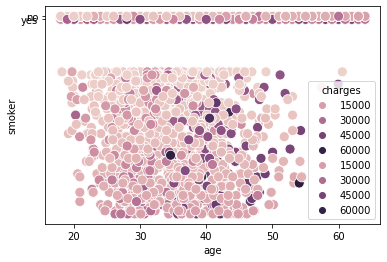

In [15]:
min_charge=min(dataframe.charges)
print(min_charge)
max_charge=max(dataframe.charges)
print(max_charge)
avg=dataframe.mean
print(dataframe)
sns.scatterplot(dataframe.age,dataframe.smoker,hue=dataframe.charges,s=100)
sns.scatterplot(dataframe.bmi,dataframe.age,hue=dataframe.charges,s=100)

Remember to commit your notebook to Jovian after every step, so that you don't lose your work.

In [16]:
!pip install jovian --upgrade -q

In [17]:
import jovian

In [18]:
jovian.commit(project='02-insurance-linear.ipynb')

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········


[jovian] Error: The current API key is invalid or expired.


[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/ms2004101007/02-insurance-linear-e7897


'https://jovian.ai/ms2004101007/02-insurance-linear-e7897'

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [38]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [39]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[56.    ,  0.    , 45.3948,  0.    ,  0.    ],
        [42.    ,  0.    , 28.4829,  2.    ,  0.    ],
        [18.    ,  1.    , 38.2299,  0.    ,  1.    ],
        ...,
        [28.    ,  1.    , 40.3959,  0.    ,  0.    ],
        [34.    ,  0.    , 26.8584,  0.    ,  0.    ],
        [46.    ,  1.    , 29.412 ,  5.    ,  0.    ]]),
 array([[10757.996266 ],
        [ 7776.5493155],
        [33579.3054305],
        ...,
        [ 3170.7812505],
        [ 4842.605108 ],
        [ 9794.0609   ]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [40]:
inputs = torch.from_numpy(inputs_array)
targets = torch.from_numpy(targets_array)
inputs=inputs.type(torch.float32)
targets=targets.type(torch.float32)

In [41]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [42]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets.**

In [43]:
val_percent = 0.17 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset,[train_size,val_size]) # Use the random_split function to split dataset into 2 parts of the desired length
print(len(train_ds))
print(len(val_ds))

1055
216


Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [45]:
batch_size = 60

In [46]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [47]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[23.0000,  0.0000, 37.3692,  2.0000,  1.0000],
        [61.0000,  1.0000, 38.2299,  0.0000,  0.0000],
        [62.0000,  1.0000, 44.2662,  0.0000,  0.0000],
        [48.0000,  1.0000, 35.8473,  1.0000,  0.0000],
        [29.0000,  0.0000, 35.5224,  0.0000,  0.0000],
        [43.0000,  0.0000, 52.6680,  0.0000,  1.0000],
        [21.0000,  1.0000, 26.4594,  0.0000,  0.0000],
        [40.0000,  0.0000, 29.0244,  1.0000,  0.0000],
        [64.0000,  1.0000, 43.2117,  0.0000,  0.0000],
        [61.0000,  1.0000, 43.7532,  0.0000,  0.0000],
        [34.0000,  0.0000, 37.9050,  1.0000,  0.0000],
        [36.0000,  0.0000, 33.1056,  4.0000,  0.0000],
        [21.0000,  1.0000, 40.5042,  0.0000,  0.0000],
        [47.0000,  0.0000, 38.0133,  0.0000,  0.0000],
        [18.0000,  1.0000, 29.0244,  0.0000,  0.0000],
        [52.0000,  0.0000, 50.9580,  3.0000,  0.0000],
        [18.0000,  0.0000, 43.6392,  0.0000,  0.0000],
        [32.0000,  0.0000, 26.9610,  1.0000,  0.0000],
  

Let's save our work by committing to Jovian.

In [103]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/ms2004101007/02-insurance-linear-regression-assignment


'https://jovian.ai/ms2004101007/02-insurance-linear-regression-assignment'

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [50]:
input_size = len(input_cols)
output_size = len(output_cols)
print(output_size)

1


**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [51]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size,output_size)            # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        xb=xb.reshape(-1,input_size)
        out = self.linear(xb)                        # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(targets,out)              # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(targets,out)  
                          # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [60]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [61]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.3833, -0.1639, -0.3745,  0.3054,  0.2347]], requires_grad=True),
 Parameter containing:
 tensor([0.0391], requires_grad=True)]

One final commit before we train the model.

In [62]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Committed successfully! https://jovian.ai/ms2004101007/02-insurance-linear-regression-assignment


'https://jovian.ai/ms2004101007/02-insurance-linear-regression-assignment'

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [63]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [64]:
result = evaluate(model,val_loader) # Use the the evaluate function
print(result)

{'val_loss': 13086.5361328125}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [65]:
epochs=10000
lr = 0.001
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 12081.5645
Epoch [40], val_loss: 11095.7178
Epoch [60], val_loss: 10216.6055
Epoch [80], val_loss: 9502.2588
Epoch [100], val_loss: 8923.4023
Epoch [120], val_loss: 8453.9834
Epoch [140], val_loss: 8085.9390
Epoch [160], val_loss: 7810.4590
Epoch [180], val_loss: 7603.2778
Epoch [200], val_loss: 7452.2598
Epoch [220], val_loss: 7340.0928
Epoch [240], val_loss: 7255.5698
Epoch [260], val_loss: 7199.9380
Epoch [280], val_loss: 7159.0762
Epoch [300], val_loss: 7130.9238
Epoch [320], val_loss: 7111.2500
Epoch [340], val_loss: 7095.0337
Epoch [360], val_loss: 7081.9062
Epoch [380], val_loss: 7070.1875
Epoch [400], val_loss: 7060.1577
Epoch [420], val_loss: 7051.7412
Epoch [440], val_loss: 7044.4165
Epoch [460], val_loss: 7037.6045
Epoch [480], val_loss: 7031.2085
Epoch [500], val_loss: 7025.1289
Epoch [520], val_loss: 7019.1880
Epoch [540], val_loss: 7013.1768
Epoch [560], val_loss: 7007.3872
Epoch [580], val_loss: 7001.6519
Epoch [600], val_loss: 6996.0146
Epoch [620]

In [66]:
epochs = 10000
lr = 0.001
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6593.7119
Epoch [40], val_loss: 6593.6602
Epoch [60], val_loss: 6593.6216
Epoch [80], val_loss: 6593.5664
Epoch [100], val_loss: 6593.5176
Epoch [120], val_loss: 6593.4634
Epoch [140], val_loss: 6593.4180
Epoch [160], val_loss: 6593.3691
Epoch [180], val_loss: 6593.3198
Epoch [200], val_loss: 6593.2734
Epoch [220], val_loss: 6593.2246
Epoch [240], val_loss: 6593.1777
Epoch [260], val_loss: 6593.1343
Epoch [280], val_loss: 6593.0938
Epoch [300], val_loss: 6593.0532
Epoch [320], val_loss: 6593.0122
Epoch [340], val_loss: 6592.9565
Epoch [360], val_loss: 6592.9116
Epoch [380], val_loss: 6592.8608
Epoch [400], val_loss: 6592.8184
Epoch [420], val_loss: 6592.7695
Epoch [440], val_loss: 6592.7168
Epoch [460], val_loss: 6592.6689
Epoch [480], val_loss: 6592.6235
Epoch [500], val_loss: 6592.5767
Epoch [520], val_loss: 6592.5352
Epoch [540], val_loss: 6592.4922
Epoch [560], val_loss: 6592.4551
Epoch [580], val_loss: 6592.4141
Epoch [600], val_loss: 6592.3696
Epoch [620], v

In [ ]:
epochs = 10000
lr = 0.01
history3 = fit(epochs, lr, model, train_loader, val_loader)

In [67]:
epochs = 5000
lr = 0.01
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6572.6792
Epoch [40], val_loss: 6572.3218
Epoch [60], val_loss: 6571.9561
Epoch [80], val_loss: 6571.5879
Epoch [100], val_loss: 6571.2085
Epoch [120], val_loss: 6570.7959
Epoch [140], val_loss: 6570.3989
Epoch [160], val_loss: 6569.9922
Epoch [180], val_loss: 6569.6084
Epoch [200], val_loss: 6569.2690
Epoch [220], val_loss: 6568.9111
Epoch [240], val_loss: 6568.5479
Epoch [260], val_loss: 6568.2051
Epoch [280], val_loss: 6567.8062
Epoch [300], val_loss: 6567.4604
Epoch [320], val_loss: 6567.0654
Epoch [340], val_loss: 6566.7275
Epoch [360], val_loss: 6566.3721
Epoch [380], val_loss: 6565.9824
Epoch [400], val_loss: 6565.6880
Epoch [420], val_loss: 6565.3643
Epoch [440], val_loss: 6565.0332
Epoch [460], val_loss: 6564.7251
Epoch [480], val_loss: 6564.3350
Epoch [500], val_loss: 6563.9941
Epoch [520], val_loss: 6563.6514
Epoch [540], val_loss: 6563.3169
Epoch [560], val_loss: 6563.0132
Epoch [580], val_loss: 6562.6997
Epoch [600], val_loss: 6562.3828
Epoch [620], v

In [68]:
epochs = 10000
lr = 0.01
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6505.6392
Epoch [40], val_loss: 6505.4277
Epoch [60], val_loss: 6505.1553
Epoch [80], val_loss: 6505.2295
Epoch [100], val_loss: 6504.7163
Epoch [120], val_loss: 6504.4956
Epoch [140], val_loss: 6504.2876
Epoch [160], val_loss: 6504.1958
Epoch [180], val_loss: 6503.8726
Epoch [200], val_loss: 6503.6904
Epoch [220], val_loss: 6503.1855
Epoch [240], val_loss: 6502.9126
Epoch [260], val_loss: 6502.9648
Epoch [280], val_loss: 6502.6191
Epoch [300], val_loss: 6502.2886
Epoch [320], val_loss: 6502.1274
Epoch [340], val_loss: 6501.9302
Epoch [360], val_loss: 6501.4004
Epoch [380], val_loss: 6501.3042
Epoch [400], val_loss: 6501.0688
Epoch [420], val_loss: 6501.0117
Epoch [440], val_loss: 6500.7075
Epoch [460], val_loss: 6500.3667
Epoch [480], val_loss: 6500.3911
Epoch [500], val_loss: 6500.0127
Epoch [520], val_loss: 6499.9102
Epoch [540], val_loss: 6499.7188
Epoch [560], val_loss: 6499.5757
Epoch [580], val_loss: 6499.5142
Epoch [600], val_loss: 6499.1040
Epoch [620], v

In [69]:
epochs = 50000
lr = 0.01
history6 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6402.3833
Epoch [40], val_loss: 6402.1958
Epoch [60], val_loss: 6401.7891
Epoch [80], val_loss: 6401.6030
Epoch [100], val_loss: 6401.4717
Epoch [120], val_loss: 6401.4429
Epoch [140], val_loss: 6401.2256
Epoch [160], val_loss: 6401.0020
Epoch [180], val_loss: 6400.8389
Epoch [200], val_loss: 6400.7593
Epoch [220], val_loss: 6400.5781
Epoch [240], val_loss: 6400.2627
Epoch [260], val_loss: 6400.1245
Epoch [280], val_loss: 6400.0522
Epoch [300], val_loss: 6399.6133
Epoch [320], val_loss: 6399.4111
Epoch [340], val_loss: 6399.1143
Epoch [360], val_loss: 6399.0430
Epoch [380], val_loss: 6398.9683
Epoch [400], val_loss: 6398.5767
Epoch [420], val_loss: 6398.6328
Epoch [440], val_loss: 6398.4346
Epoch [460], val_loss: 6398.3154
Epoch [480], val_loss: 6398.1499
Epoch [500], val_loss: 6397.7251
Epoch [520], val_loss: 6397.7354
Epoch [540], val_loss: 6397.5459
Epoch [560], val_loss: 6397.3882
Epoch [580], val_loss: 6397.1221
Epoch [600], val_loss: 6396.9053
Epoch [620], v

In [70]:
epochs = 50000
lr = 0.01
history7 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 5940.8413
Epoch [40], val_loss: 5940.6650
Epoch [60], val_loss: 5940.4146
Epoch [80], val_loss: 5940.2178
Epoch [100], val_loss: 5940.1665
Epoch [120], val_loss: 5939.8428
Epoch [140], val_loss: 5939.7773
Epoch [160], val_loss: 5939.5078
Epoch [180], val_loss: 5939.4019
Epoch [200], val_loss: 5939.1387
Epoch [220], val_loss: 5938.9844
Epoch [240], val_loss: 5938.9058
Epoch [260], val_loss: 5938.7021
Epoch [280], val_loss: 5938.4604
Epoch [300], val_loss: 5938.3735
Epoch [320], val_loss: 5938.1763
Epoch [340], val_loss: 5938.1758
Epoch [360], val_loss: 5937.6914
Epoch [380], val_loss: 5937.4854
Epoch [400], val_loss: 5937.5127
Epoch [420], val_loss: 5937.1611
Epoch [440], val_loss: 5937.0342
Epoch [460], val_loss: 5936.8042
Epoch [480], val_loss: 5936.7061
Epoch [500], val_loss: 5936.4038
Epoch [520], val_loss: 5936.3965
Epoch [540], val_loss: 5936.1768
Epoch [560], val_loss: 5935.9214
Epoch [580], val_loss: 5935.7910
Epoch [600], val_loss: 5935.5781
Epoch [620], v

In [71]:
epochs = 10000
lr = 0.01
history8 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 5509.3076
Epoch [40], val_loss: 5509.1572
Epoch [60], val_loss: 5508.9819
Epoch [80], val_loss: 5508.8032
Epoch [100], val_loss: 5508.6226
Epoch [120], val_loss: 5508.5420
Epoch [140], val_loss: 5508.3242
Epoch [160], val_loss: 5508.1494
Epoch [180], val_loss: 5508.0752
Epoch [200], val_loss: 5507.8516
Epoch [220], val_loss: 5507.6328
Epoch [240], val_loss: 5507.4829
Epoch [260], val_loss: 5507.3193
Epoch [280], val_loss: 5507.1650
Epoch [300], val_loss: 5507.0547
Epoch [320], val_loss: 5506.8242
Epoch [340], val_loss: 5506.6411
Epoch [360], val_loss: 5506.4893
Epoch [380], val_loss: 5506.3242
Epoch [400], val_loss: 5506.2158
Epoch [420], val_loss: 5506.0488
Epoch [440], val_loss: 5505.9038
Epoch [460], val_loss: 5505.6914
Epoch [480], val_loss: 5505.5215
Epoch [500], val_loss: 5505.3379
Epoch [520], val_loss: 5505.1768
Epoch [540], val_loss: 5505.0552
Epoch [560], val_loss: 5504.8984
Epoch [580], val_loss: 5504.8340
Epoch [600], val_loss: 5504.5532
Epoch [620], v

In [72]:
epochs = 50000
lr = 0.01
history9 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 5426.9946
Epoch [40], val_loss: 5426.8467
Epoch [60], val_loss: 5426.6646
Epoch [80], val_loss: 5426.4897
Epoch [100], val_loss: 5426.3320
Epoch [120], val_loss: 5426.2041
Epoch [140], val_loss: 5426.0391
Epoch [160], val_loss: 5425.8301
Epoch [180], val_loss: 5425.6777
Epoch [200], val_loss: 5425.5415
Epoch [220], val_loss: 5425.3335
Epoch [240], val_loss: 5425.1685
Epoch [260], val_loss: 5425.0303
Epoch [280], val_loss: 5424.8389
Epoch [300], val_loss: 5424.7114
Epoch [320], val_loss: 5424.5171
Epoch [340], val_loss: 5424.3574
Epoch [360], val_loss: 5424.2246
Epoch [380], val_loss: 5424.0039
Epoch [400], val_loss: 5423.8652
Epoch [420], val_loss: 5423.7041
Epoch [440], val_loss: 5423.5762
Epoch [460], val_loss: 5423.4121
Epoch [480], val_loss: 5423.2139
Epoch [500], val_loss: 5423.0776
Epoch [520], val_loss: 5422.8716
Epoch [540], val_loss: 5422.6904
Epoch [560], val_loss: 5422.5674
Epoch [580], val_loss: 5422.3594
Epoch [600], val_loss: 5422.2227
Epoch [620], v

In [73]:
epochs = 50000
lr = 0.01
history10 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 5016.5625
Epoch [40], val_loss: 5016.3867
Epoch [60], val_loss: 5016.2422
Epoch [80], val_loss: 5016.0752
Epoch [100], val_loss: 5015.9609
Epoch [120], val_loss: 5015.7651
Epoch [140], val_loss: 5015.5566
Epoch [160], val_loss: 5015.5039
Epoch [180], val_loss: 5015.2300
Epoch [200], val_loss: 5015.2021
Epoch [220], val_loss: 5014.9443
Epoch [240], val_loss: 5014.7866
Epoch [260], val_loss: 5014.6636
Epoch [280], val_loss: 5014.5063
Epoch [300], val_loss: 5014.2319
Epoch [320], val_loss: 5014.0942
Epoch [340], val_loss: 5013.9272
Epoch [360], val_loss: 5013.7632
Epoch [380], val_loss: 5013.6426
Epoch [400], val_loss: 5013.4580
Epoch [420], val_loss: 5013.3828
Epoch [440], val_loss: 5013.1689
Epoch [460], val_loss: 5013.0229
Epoch [480], val_loss: 5012.8418
Epoch [500], val_loss: 5012.6138
Epoch [520], val_loss: 5012.4937
Epoch [540], val_loss: 5012.2993
Epoch [560], val_loss: 5012.2041
Epoch [580], val_loss: 5011.9854
Epoch [600], val_loss: 5011.7637
Epoch [620], v

In [74]:
epochs = 20000
lr = 0.01
history11 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 4609.8647
Epoch [40], val_loss: 4609.7031
Epoch [60], val_loss: 4609.5415
Epoch [80], val_loss: 4609.3779
Epoch [100], val_loss: 4609.2188
Epoch [120], val_loss: 4609.0625
Epoch [140], val_loss: 4608.8960
Epoch [160], val_loss: 4608.7354
Epoch [180], val_loss: 4608.5762
Epoch [200], val_loss: 4608.4121
Epoch [220], val_loss: 4608.2515
Epoch [240], val_loss: 4608.0908
Epoch [260], val_loss: 4607.9287
Epoch [280], val_loss: 4607.7705
Epoch [300], val_loss: 4607.6079
Epoch [320], val_loss: 4607.4463
Epoch [340], val_loss: 4607.2861
Epoch [360], val_loss: 4607.1255
Epoch [380], val_loss: 4606.9658
Epoch [400], val_loss: 4606.8027
Epoch [420], val_loss: 4606.6440
Epoch [440], val_loss: 4606.4795
Epoch [460], val_loss: 4606.3208
Epoch [480], val_loss: 4606.1558
Epoch [500], val_loss: 4605.9985
Epoch [520], val_loss: 4605.8369
Epoch [540], val_loss: 4605.6748
Epoch [560], val_loss: 4605.5132
Epoch [580], val_loss: 4605.3501
Epoch [600], val_loss: 4605.1895
Epoch [620], v

In [75]:
epochs = 50000
lr = 0.1
history13 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 4444.0166
Epoch [40], val_loss: 4443.8262
Epoch [60], val_loss: 4443.6572
Epoch [80], val_loss: 4443.4907
Epoch [100], val_loss: 4443.3149
Epoch [120], val_loss: 4443.1943
Epoch [140], val_loss: 4443.0215
Epoch [160], val_loss: 4442.8525
Epoch [180], val_loss: 4442.6836
Epoch [200], val_loss: 4442.5132
Epoch [220], val_loss: 4442.3589
Epoch [240], val_loss: 4442.1885
Epoch [260], val_loss: 4442.0112
Epoch [280], val_loss: 4441.8511
Epoch [300], val_loss: 4441.6792
Epoch [320], val_loss: 4441.4976
Epoch [340], val_loss: 4441.3364
Epoch [360], val_loss: 4441.1855
Epoch [380], val_loss: 4440.9961
Epoch [400], val_loss: 4440.8872
Epoch [420], val_loss: 4440.6777
Epoch [440], val_loss: 4440.5166
Epoch [460], val_loss: 4440.3594
Epoch [480], val_loss: 4440.1670
Epoch [500], val_loss: 4440.0303
Epoch [520], val_loss: 4439.8613
Epoch [540], val_loss: 4439.7114
Epoch [560], val_loss: 4439.5239
Epoch [580], val_loss: 4439.4062
Epoch [600], val_loss: 4439.1836
Epoch [620], v

**Q: What is the final validation loss of your model?**

In [77]:
epochs = 5000
lr = 0.1
history14 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 3995.0979
Epoch [40], val_loss: 3989.7390
Epoch [60], val_loss: 3988.0962
Epoch [80], val_loss: 3987.4229
Epoch [100], val_loss: 3985.6584
Epoch [120], val_loss: 3984.3499
Epoch [140], val_loss: 3983.1147
Epoch [160], val_loss: 3980.8135
Epoch [180], val_loss: 3981.5376
Epoch [200], val_loss: 3978.0796
Epoch [220], val_loss: 3976.8445
Epoch [240], val_loss: 3975.7927
Epoch [260], val_loss: 3974.0044
Epoch [280], val_loss: 3975.4546
Epoch [300], val_loss: 3971.5623
Epoch [320], val_loss: 3970.4766
Epoch [340], val_loss: 3968.4265
Epoch [360], val_loss: 3967.2485
Epoch [380], val_loss: 3967.8374
Epoch [400], val_loss: 3964.4434
Epoch [420], val_loss: 3964.3635
Epoch [440], val_loss: 3961.5776
Epoch [460], val_loss: 3965.0410
Epoch [480], val_loss: 3959.3862
Epoch [500], val_loss: 3959.0906
Epoch [520], val_loss: 3958.3955
Epoch [540], val_loss: 3956.4551
Epoch [560], val_loss: 3957.8357
Epoch [580], val_loss: 3951.9158
Epoch [600], val_loss: 3951.5354
Epoch [620], v

In [78]:
epochs = 10000
lr = 0.1
history15 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 3697.2686
Epoch [40], val_loss: 3696.1631
Epoch [60], val_loss: 3695.1980
Epoch [80], val_loss: 3703.1978
Epoch [100], val_loss: 3693.8315
Epoch [120], val_loss: 3697.5723
Epoch [140], val_loss: 3694.1682
Epoch [160], val_loss: 3692.6406
Epoch [180], val_loss: 3692.1370
Epoch [200], val_loss: 3690.0859
Epoch [220], val_loss: 3691.1062
Epoch [240], val_loss: 3691.1218
Epoch [260], val_loss: 3686.6538
Epoch [280], val_loss: 3690.3503
Epoch [300], val_loss: 3693.9436
Epoch [320], val_loss: 3687.5247
Epoch [340], val_loss: 3685.7117
Epoch [360], val_loss: 3683.4719
Epoch [380], val_loss: 3681.9651
Epoch [400], val_loss: 3682.7703
Epoch [420], val_loss: 3681.3809
Epoch [440], val_loss: 3684.3601
Epoch [460], val_loss: 3682.1101
Epoch [480], val_loss: 3681.6689
Epoch [500], val_loss: 3678.0271
Epoch [520], val_loss: 3677.6885
Epoch [540], val_loss: 3677.7695
Epoch [560], val_loss: 3675.7654
Epoch [580], val_loss: 3676.0850
Epoch [600], val_loss: 3674.3267
Epoch [620], v

In [79]:
epochs = 100
lr = 0.2
history14 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 3504.0498
Epoch [40], val_loss: 3502.1023
Epoch [60], val_loss: 3519.7329
Epoch [80], val_loss: 3501.4683
Epoch [100], val_loss: 3501.6399


In [80]:
epochs = 2000
lr = 0.2
history15 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 3503.9700
Epoch [40], val_loss: 3506.7832
Epoch [60], val_loss: 3502.6150
Epoch [80], val_loss: 3499.7681
Epoch [100], val_loss: 3501.8716
Epoch [120], val_loss: 3508.3423
Epoch [140], val_loss: 3501.2988
Epoch [160], val_loss: 3513.2363
Epoch [180], val_loss: 3501.2378
Epoch [200], val_loss: 3497.8911
Epoch [220], val_loss: 3515.3369
Epoch [240], val_loss: 3498.2642
Epoch [260], val_loss: 3496.8074
Epoch [280], val_loss: 3506.6409
Epoch [300], val_loss: 3496.1626
Epoch [320], val_loss: 3496.8567
Epoch [340], val_loss: 3495.7490
Epoch [360], val_loss: 3496.5759
Epoch [380], val_loss: 3496.5652
Epoch [400], val_loss: 3507.8706
Epoch [420], val_loss: 3495.5039
Epoch [440], val_loss: 3495.4624
Epoch [460], val_loss: 3493.9253
Epoch [480], val_loss: 3495.9050
Epoch [500], val_loss: 3501.6323
Epoch [520], val_loss: 3508.6885
Epoch [540], val_loss: 3495.3784
Epoch [560], val_loss: 3504.8555
Epoch [580], val_loss: 3505.6812
Epoch [600], val_loss: 3501.9336
Epoch [620], v

In [81]:
epochs = 2000
lr = 0.3
history14 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 3479.5715
Epoch [40], val_loss: 3482.4092
Epoch [60], val_loss: 3492.8005
Epoch [80], val_loss: 3478.6775
Epoch [100], val_loss: 3492.1025
Epoch [120], val_loss: 3491.7625
Epoch [140], val_loss: 3479.7898
Epoch [160], val_loss: 3531.1011
Epoch [180], val_loss: 3478.0376
Epoch [200], val_loss: 3523.1289
Epoch [220], val_loss: 3531.3987
Epoch [240], val_loss: 3503.2520
Epoch [260], val_loss: 3477.6201
Epoch [280], val_loss: 3477.2996
Epoch [300], val_loss: 3477.5830
Epoch [320], val_loss: 3482.0591
Epoch [340], val_loss: 3486.1724
Epoch [360], val_loss: 3477.8369
Epoch [380], val_loss: 3491.0999
Epoch [400], val_loss: 3476.3599
Epoch [420], val_loss: 3525.4468
Epoch [440], val_loss: 3483.7644
Epoch [460], val_loss: 3478.3540
Epoch [480], val_loss: 3524.5610
Epoch [500], val_loss: 3476.1516
Epoch [520], val_loss: 3474.8916
Epoch [540], val_loss: 3483.4775
Epoch [560], val_loss: 3476.4016
Epoch [580], val_loss: 3485.8445
Epoch [600], val_loss: 3475.5908
Epoch [620], v

In [82]:
epochs = 2000
lr = 0.1
history14 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 3475.5605
Epoch [40], val_loss: 3475.0305
Epoch [60], val_loss: 3473.2163
Epoch [80], val_loss: 3494.4568
Epoch [100], val_loss: 3469.6355
Epoch [120], val_loss: 3478.1958
Epoch [140], val_loss: 3474.9429
Epoch [160], val_loss: 3478.9807
Epoch [180], val_loss: 3477.4050
Epoch [200], val_loss: 3485.2312
Epoch [220], val_loss: 3473.1631
Epoch [240], val_loss: 3485.1506
Epoch [260], val_loss: 3472.6404
Epoch [280], val_loss: 3473.1392
Epoch [300], val_loss: 3481.2996
Epoch [320], val_loss: 3475.5903
Epoch [340], val_loss: 3474.6030
Epoch [360], val_loss: 3476.4229
Epoch [380], val_loss: 3474.1912
Epoch [400], val_loss: 3474.0356
Epoch [420], val_loss: 3474.6567
Epoch [440], val_loss: 3469.5117
Epoch [460], val_loss: 3480.2896
Epoch [480], val_loss: 3477.6084
Epoch [500], val_loss: 3477.7031
Epoch [520], val_loss: 3471.1196
Epoch [540], val_loss: 3471.6689
Epoch [560], val_loss: 3485.2886
Epoch [580], val_loss: 3473.8010
Epoch [600], val_loss: 3473.4001
Epoch [620], v

In [94]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/ms2004101007/02-insurance-linear-regression-assignment


'https://jovian.ai/ms2004101007/02-insurance-linear-regression-assignment'

In [104]:
val_loss = 3468.8804

In [105]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/ms2004101007/02-insurance-linear-regression-assignment


'https://jovian.ai/ms2004101007/02-insurance-linear-regression-assignment'

Let's log the final validation loss to Jovian and commit the notebook

In [106]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [107]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/ms2004101007/02-insurance-linear-regression-assignment


'https://jovian.ai/ms2004101007/02-insurance-linear-regression-assignment'

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [86]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions =  model(inputs)             # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [87]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([52.0000,  1.0000, 41.8380,  0.0000,  0.0000])
Target: tensor([8870.2285])
Prediction: tensor([9535.9229])


In [88]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([44.0000,  1.0000, 42.2940,  2.0000,  0.0000])
Target: tensor([7508.1270])
Prediction: tensor([8268.9688])


In [89]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([32.0000,  1.0000, 53.0442,  2.0000,  0.0000])
Target: tensor([4545.7969])
Prediction: tensor([5342.4961])


Are you happy with your model's predictions? Try to improve them further.

## (Optional) Step 6: Try another dataset & blog about it

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to replicate this notebook for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patterns in machine learning from problem-specific details.You can use one of these starer notebooks (just change the dataset):

- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog. 

Don't forget to share your work on the forum: https://jovian.ai/forum/t/linear-regression-and-logistic-regression-notebooks-and-blog-posts/14039

In [108]:
jovian.commit(project=project_name, environment=None)
jovian.commit(project=project_name, environment=None) # try again, kaggle fails sometimes

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/ms2004101007/02-insurance-linear-regression-assignment
[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/ms2004101007/02-insurance-linear-regression-assignment


'https://jovian.ai/ms2004101007/02-insurance-linear-regression-assignment'

In [109]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/ms2004101007/02-insurance-linear-regression-assignment


'https://jovian.ai/ms2004101007/02-insurance-linear-regression-assignment'